In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import metrics
from pandas.api.types import is_string_dtype,is_numeric_dtype
import re
import math

from IPython.display import display

In [2]:
data = pd.read_csv(r'C:\Users\elcot\Downloads\rossmann-store-sales\train.csv')
print(data.shape)
data.head()

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [20]:
data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [57]:
data.isnull().sum().sort_index()/len(data)

Customers           0.0
Day                 0.0
DayOfWeek           0.0
Dayofweek           0.0
Dayofyear           0.0
Elapsed             0.0
Is_month_end        0.0
Is_month_start      0.0
Is_quarter_end      0.0
Is_quarter_start    0.0
Is_year_end         0.0
Is_year_start       0.0
Month               0.0
Open                0.0
Promo               0.0
Sales               0.0
SchoolHoliday       0.0
StateHoliday        0.0
Store               0.0
Week                0.0
Year                0.0
dtype: float64

We have Zero Sales for some days

In [3]:
to_drop = data[(data.Sales == 0) & (data.Open == 1)]
ind = to_drop.index

In [4]:
data.drop(index = ind,axis = 0,inplace = True)
len(data)

1017155

In [5]:
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

In [6]:
add_datepart(data, 'Date')

In [7]:
def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
        
def get_sample(df,n):    
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    
    if not ignore_flds: 
        ignore_flds=[]
    if not skip_flds: 
        skip_flds=[]
    if subset: 
        df = get_sample(df,subset)
    else: 
        df = df.copy()
        
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: 
        preproc_fn(df)
    if y_fld is None: 
        y = None
    else:
        if not is_numeric_dtype(df[y_fld]): 
            df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: 
        na_dict = {}
    else: 
        na_dict = na_dict.copy()
        
    na_dict_initial = na_dict.copy()
    
    for n,c in df.items(): 
        na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
        
    if do_scale: 
        mapper = scale_vars(df, mapper)
    for n,c in df.items(): 
        numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: 
        res = res + [mapper]
    return res

In [8]:
df, y, nas = proc_df(data,'Sales')

In [10]:
m = RandomForestRegressor(n_estimators=1).fit(df,y); m.score(df,y)

0.9632447750869219

In [11]:
def split_val(a,n): return a[:n].copy(), a[n:].copy()

In [12]:
n_val = 200000
n_trn = len(data) - n_val

X_train, X_valid = split_val(df,n_trn)
Y_train, Y_valid = split_val(y,n_trn)

X_train.shape, Y_train.shape, X_valid.shape,Y_valid.shape

((817155, 20), (817155,), (200000, 20), (200000,))

In [14]:
m = RandomForestRegressor(n_estimators=1).fit(X_train,Y_train); m.score(X_valid,Y_valid)

0.8864729975206184

In [33]:
def rmspe(y_pred,y_act):
    
    rms = (((y_act-y_pred)/y_act)**2)
    np.nan_to_num(rms,copy=False)
    return math.sqrt(rms.mean())

def print_score(m):
    res = [rmspe(m.predict(X_train),Y_train), rmspe(m.predict(X_valid),Y_valid), m.score(X_train,Y_train), m.score(X_valid, Y_valid)]
    
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
        
    return res

In [16]:
m = RandomForestRegressor(n_estimators=1).fit(X_train,Y_train)

print_score(m)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[0.10974335689179625,
 0.19642690915608108,
 0.9602818179678707,
 0.8881756004206268]

In [17]:
n_val = 200000
n_trn = len(df) - n_val

X_train, X_valid = split_val(df,n_trn)
Y_train, Y_valid = split_val(y,n_trn)

m = RandomForestRegressor(n_estimators = 1, max_features = 0.5, oob_score = True, min_samples_leaf=3)

m.fit(X_train,Y_train)
print_score(m)

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[0.15701669258130438,
 0.23533265977018566,
 0.9240069486281777,
 0.8607490094272295,
 -1.1146236191125887]

In [34]:
m = RandomForestRegressor(n_estimators = 10, max_features = 0.5, oob_score = True, min_samples_leaf=3)

m.fit(X_train,Y_train)
print_score(m)

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[   0.         8718.81619048 9123.40674603 ... 7732.97666667 4666.50142857
 3188.40416667] [   0 7494 7628 ... 9053 5224 2763]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[6849.7397619  6081.7625     3918.47642857 ...    0.            0.
    0.        ] [6470 5922 6027 ...    0    0    0]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[inf, inf, 0.9596229619562654, 0.9164489926525723, 0.8711621234983917]

In [61]:
m = RandomForestRegressor(n_estimators = 20, max_features = 0.5, oob_score = True, min_samples_leaf=3)

m.fit(X_train,Y_train)
print_score(m)

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[   0.         8745.08875472 9219.03562702 ... 7422.77460317 4662.64935786
 3070.39604798] [   0 7494 7628 ... 9053 5224 2763]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[6921.19256133 5881.0385119  4464.05660714 ...    0.            0.
    0.        ] [6470 5922 6027 ...    0    0    0]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[inf, inf, 0.9619457485185124, 0.9201854695003979, 0.9132669866357537]

In [139]:
m = RandomForestRegressor(n_estimators = 40, max_features = 0.5, oob_score = True, min_samples_leaf=3)

m.fit(X_train,Y_train)
print_score(m)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[inf, inf, 0.9629323270824328, 0.9223385057774386, 0.9180286910148611]

In [62]:
pred = np.stack([t.predict(X_valid) for t in m.estimators_])

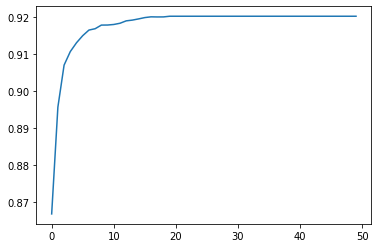

In [63]:
plt.plot([metrics.r2_score(Y_valid, np.mean(pred[:i+1], axis=0)) for i in range(40)]);

# Feature Importance

In [64]:
def rf_feat_importance(m,df):
    
    return pd.DataFrame({'cols': df.columns , 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [65]:
fi = rf_feat_importance(m, df)

fi

,cols,imp
2,Customers,6.378067e-01
3,Open,1.283525e-01
11,Dayofweek,6.505646e-02
0,Store,4.941055e-02
4,Promo,4.931929e-02
1,DayOfWeek,2.995475e-02
12,Dayofyear,9.213115e-03
5,StateHoliday,8.796206e-03
10,Day,6.689054e-03
19,Elapsed,5.418779e-03


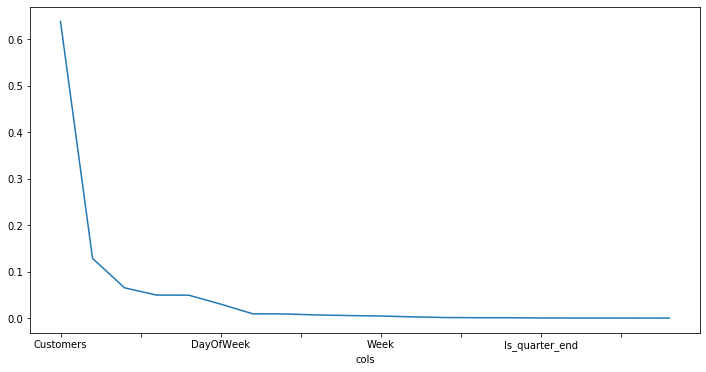

In [67]:
fi.plot('cols', 'imp', figsize=(12,6), legend=False);

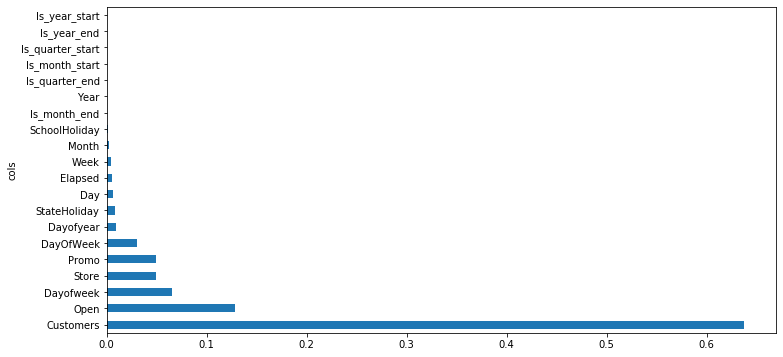

In [110]:
fi.plot('cols', 'imp','barh', figsize=(12,6), legend=False)

In [68]:
to_keep = fi[fi['imp']>0.002].cols

In [69]:
df_keep = df[to_keep].copy()
X_train,X_valid = split_val(df_keep, n_trn)
Y_train,Y_valid = split_val(y, n_trn)

m = RandomForestRegressor(n_estimators=1).fit(X_train,Y_train)

print_score(m)

[    0.  7687.  7628. ... 13718.  5224.  2763.] [   0 7494 7628 ... 9053 5224 2763]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[6306. 6360. 3855. ...    0.    0.    0.] [6470 5922 6027 ...    0    0    0]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[0.1127380117864608,
 0.20174968268302926,
 0.958738355398772,
 0.8852138335027612]

In [101]:
X_valid['preds_std'] = preds_std
X_valid['preds'] = preds

# One hot Encoding

In [113]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

def train_cats(df):

    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [115]:
train_cats(data)

In [118]:
df_trn, y_trn, nas = proc_df(data, 'Sales', max_n_cat=7)
X_train, X_valid = split_val(df_trn, n_trn)

m = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, Y_train)
print_score(m)

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[   0.         9001.09063492 9346.35146825 ... 8368.91444444 4734.85369048
 2906.91220779] [   0 7494 7628 ... 9053 5224 2763]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[7260.2652381  6483.19666667 4777.79865079 ...    0.            0.
    0.        ] [6470 5922 6027 ...    0    0    0]


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[inf, inf, 0.958799040080789, 0.91653333602665, 0.8697664152033937]

In [124]:
fi = rf_feat_importance(m, df_trn)

fi

,cols,imp
2,Customers,0.573149
3,Open,0.209624
0,Store,0.049321
10,Dayofweek,0.047679
4,Promo,0.044200
1,DayOfWeek,0.043718
11,Dayofyear,0.009423
8,Week,0.006217
9,Day,0.005709
18,Elapsed,0.005182


One hot encoding doesn't show any difference in prediction

# Removing Redunant Features

In [125]:
from scipy.cluster import hierarchy as hc
import scipy

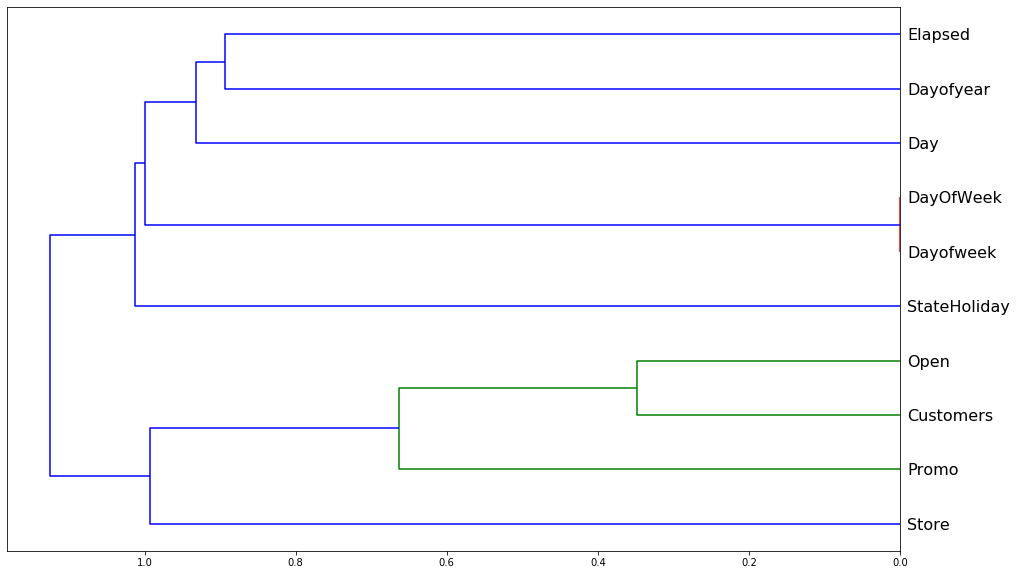

In [131]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)

corr_cond = hc.distance.squareform(1-corr)
z = hc.linkage(corr_cond, method='average')

fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [138]:
df_keep.drop(['Dayofweek'], inplace = True, axis = 1)

In [139]:
df_keep.columns

Index(['Customers', 'Open', 'Store', 'Promo', 'DayOfWeek', 'Dayofyear',
       'StateHoliday', 'Day', 'Elapsed'],
      dtype='object')

In [141]:
from treeinterpreter import treeinterpreter as ti

ERROR: Could not find a version that satisfies the requirement treeinterpreter (from versions: none)
ERROR: No matching distribution found for treeinterpreter


ModuleNotFoundError: No module named 'treeinterpreter'

In [142]:
df_train, df_valid = split_val(df_keep, n_trn)

m = RandomForestRegressor(n_estimators=10, max_features=0.5, n_jobs=-1,oob_score=True)
m.fit(df_train,Y_train)
print_score(m)

D:\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


ValueError: Number of features of the model must match the input. Model n_features is 9 and input n_features is 25 